In [7]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from tools import BlindColours, zero_balanced_weights
from lambda_balanced import  QQT_lambda_balanced3
from empiricalTest import LinearNetwork, get_random_regression_task
from balanced_weights import balanced_weights


In [8]:
blind_colours = BlindColours().get_colours()

In [9]:
def get_ntk(w1w1, w2w2, X, out_dim):

    return  np.kron(np.eye(out_dim), X.T @ w1w1 @ X) + np.kron(w2w2, X.T @ X)

    

In [10]:
in_dim = 3
hidden_dim = 3
out_dim = 3

batch_size = 10
learning_rate = 0.00001
training_steps = 10000


output_empirical = {}
output_analytical = {}

ws_empirical = {}
ws_analytical = {}

w1w1s_empirical = {}
w1w1s_analytical = {}

w2w2s_empirical = {}
w2w2s_analytical = {}

ntks_empirical = {}
ntks_analytical = {}

losses_list_empirical = {}
losses_list_analytical = {}




X, Y = get_random_regression_task(batch_size, in_dim, out_dim)


##Run model, keep track of w2, w1, log it into all of these lists
lmdas = [-1000, -100, -10, -1, 0.01, 1, 10, 100, 1000]

# lmdas= [0.01, 0.01]

for lmda in lmdas:
    
    # if lmda > 0:
    #     a = np.sqrt(lmda) + 1
    #     b = np.sqrt(2 * np.sqrt(lmda))
    # else:
    #     a = np.sqrt(2 * np.sqrt(np.abs(lmda)))
    #     b = np.sqrt(np.abs(lmda)) + 1

    # init_w1 = np.eye(hidden_dim) * a 
    # init_w2 = np.eye(hidden_dim) * b 

    init_w1, init_w2, _, q = balanced_weights(in_dim, hidden_dim, out_dim)
    while (np.sign(q[0][0]) != np.sign(lmda)):
        init_w1, init_w2, _, q = balanced_weights(in_dim, hidden_dim, out_dim)
    
    factor = np.sqrt(lmda / q[0][0])

    init_w1 = init_w1 * factor 
    init_w2 = init_w2 * factor

    print(init_w2.T @ init_w2 - init_w1 @ init_w1.T)
    

    model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1.copy(), init_w2.copy())
    w1s, w2s, losses = model.train(X, Y, training_steps, learning_rate)

    ws_empirical[lmda] = [w2 @ w1 for (w2, w1) in zip(w2s, w1s)]
    ws_empirical[lmda] = np.expand_dims(ws_empirical[lmda], axis = 1)

    output_empirical[lmda] = [w @ X for w in ws_empirical[lmda]]
 
    w1w1s_empirical[lmda] = np.array([w1.T @ w1 for w1 in w1s])
    w2w2s_empirical[lmda] = np.array([w2 @ w2.T for w2 in w2s])

    losses_list_empirical[lmda] = [1/(2*batch_size) * np.linalg.norm(w @ X - Y)**2 for w in ws_empirical[lmda]]

    ntks_empirical[lmda] = np.array([get_ntk(w1w1, w2w2, X, out_dim) for (w1w1, w2w2) in zip(w1w1s_empirical[lmda], w2w2s_empirical[lmda])])


    analytical = QQT_lambda_balanced3(init_w1.copy(), init_w2.copy(), X.T, Y.T, False)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])

    ws_analytical[lmda] = np.array([a[in_dim:, :out_dim] for a in analytical])
    output_analytical[lmda] = [w @ X for w in ws_analytical[lmda]]
    
    w1w1s_analytical[lmda] = np.array([a[:hidden_dim, :hidden_dim] for a in analytical])
    w2w2s_analytical[lmda] = np.array([a[hidden_dim:, hidden_dim:] for a in analytical])

    ntks_analytical[lmda] = np.array([get_ntk(w1w1, w2w2, X, out_dim) for (w1w1, w2w2) in zip(w1w1s_empirical[lmda], w2w2s_empirical[lmda])])

    losses_list_analytical[lmda] = [1/(2*batch_size) * np.linalg.norm(w @ X - Y, ord='fro')**2 for w in ws_analytical[lmda]]
    

##Run analytical, keep log all of the stuff into these lists


[[ 1.00000000e+03  2.55795385e-13 -5.11590770e-13]
 [ 2.55795385e-13  1.00000000e+03  2.41584530e-13]
 [-5.11590770e-13  2.41584530e-13  1.00000000e+03]]
[[ 1.00000000e+02  1.42108547e-14 -7.10542736e-15]
 [ 1.42108547e-14  1.00000000e+02  7.81597009e-14]
 [-7.10542736e-15  7.81597009e-14  1.00000000e+02]]
[[ 1.00000000e+01 -3.55271368e-15 -1.55431223e-15]
 [-3.55271368e-15  1.00000000e+01  7.10542736e-15]
 [-1.55431223e-15  7.10542736e-15  1.00000000e+01]]
[[ 1.00000000e+00 -3.33066907e-16  4.44089210e-16]
 [-3.33066907e-16  1.00000000e+00  3.33066907e-16]
 [ 4.44089210e-16  3.33066907e-16  1.00000000e+00]]
[[-1.00000000e-02  2.16840434e-18 -2.16840434e-18]
 [ 2.16840434e-18 -1.00000000e-02 -5.20417043e-18]
 [-2.16840434e-18 -5.20417043e-18 -1.00000000e-02]]
[[-1.00000000e+00 -1.33226763e-15  3.60822483e-16]
 [-1.33226763e-15 -1.00000000e+00 -2.22044605e-15]
 [ 3.60822483e-16 -2.22044605e-15 -1.00000000e+00]]
[[-1.00000000e+01  1.33226763e-14  5.77315973e-15]
 [ 1.33226763e-14 -1.0000

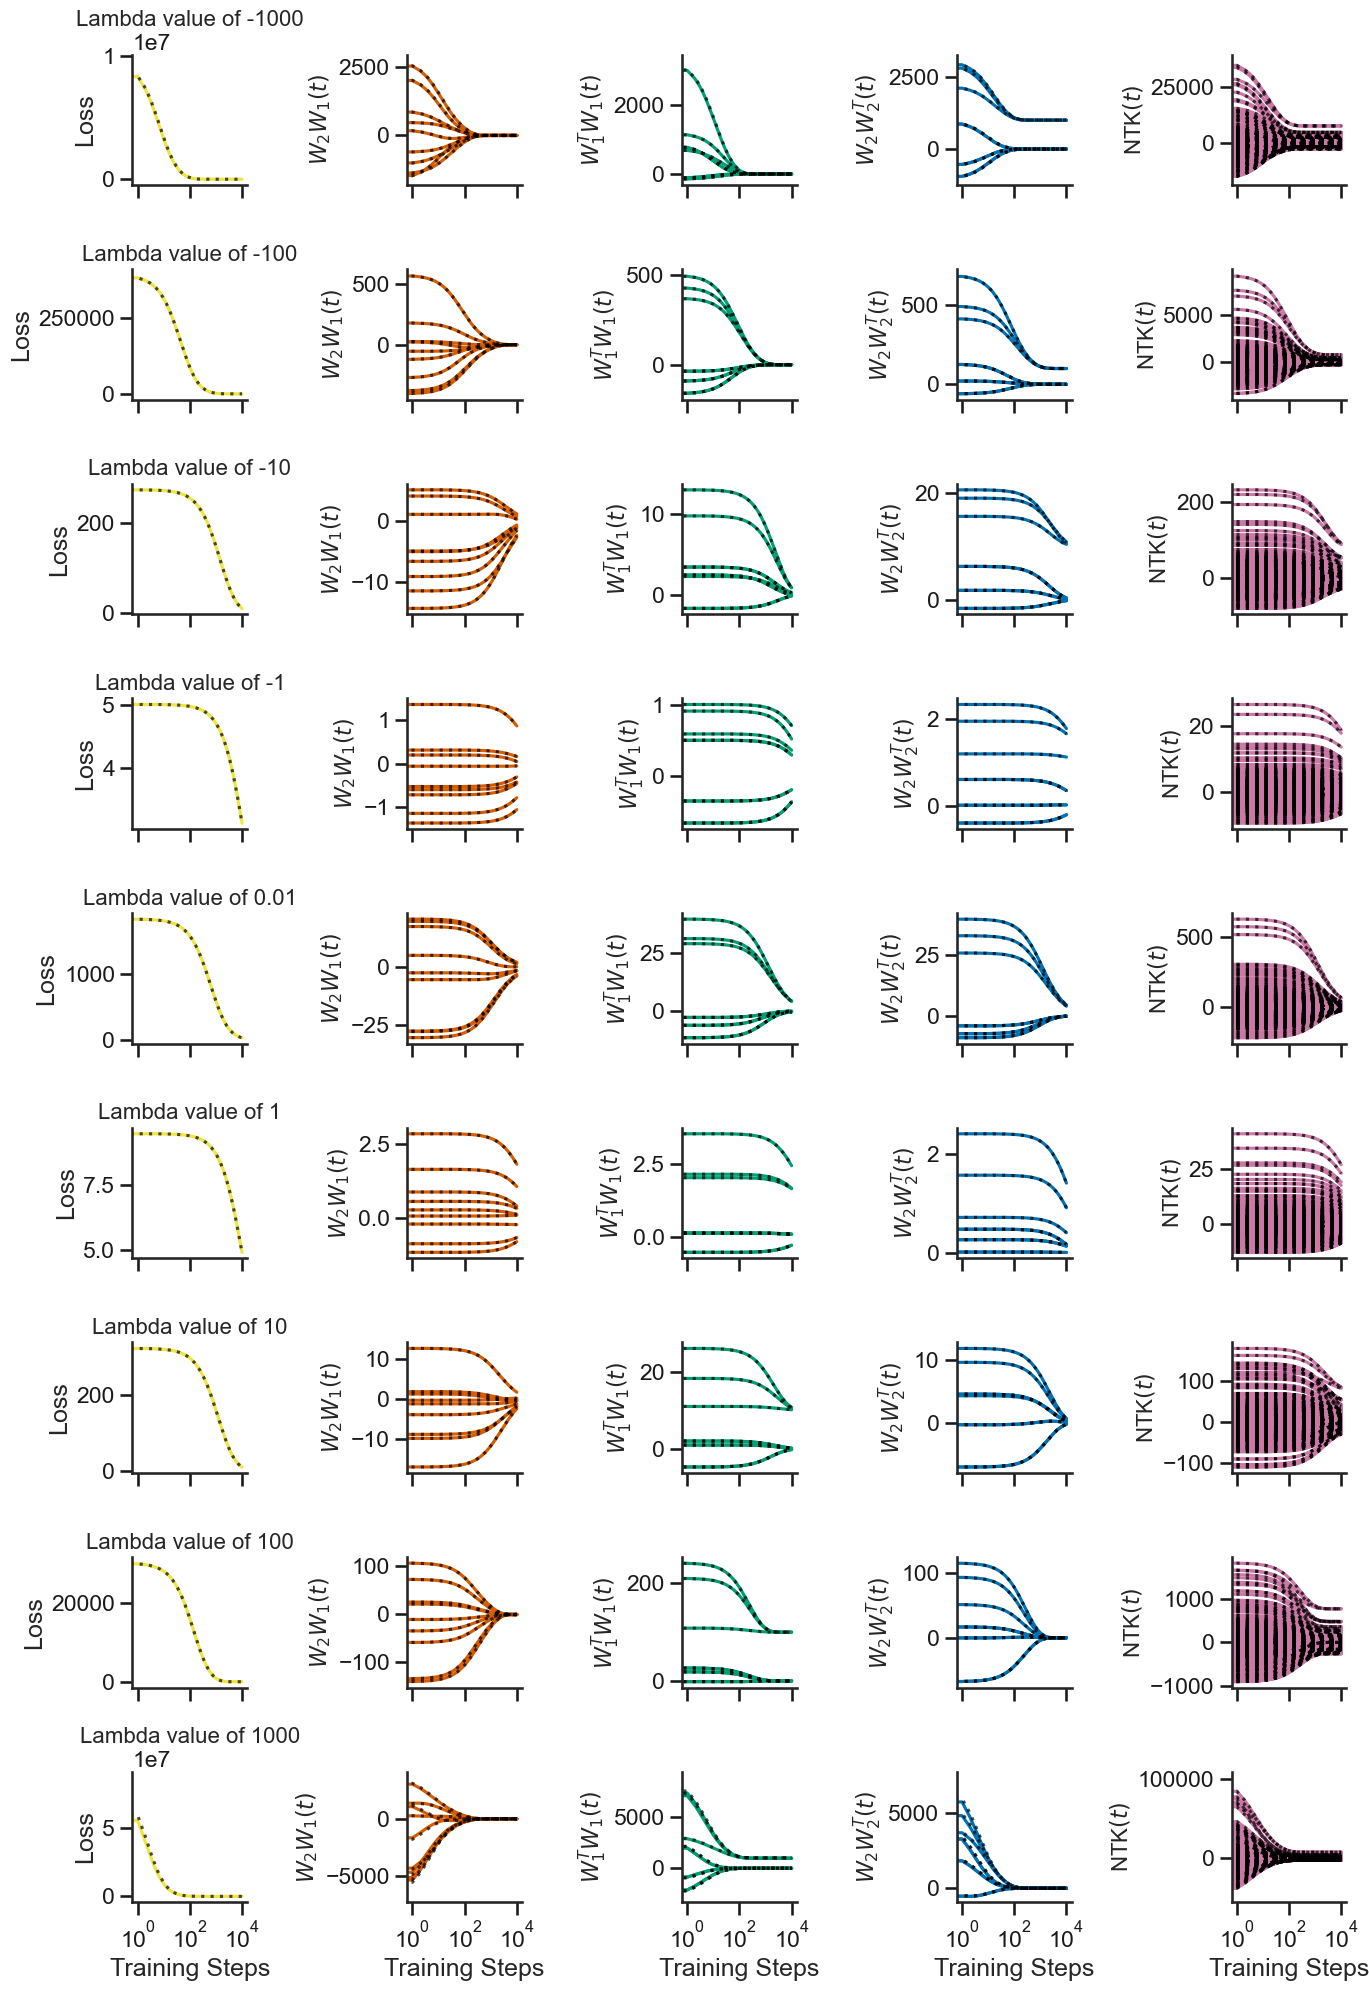

In [6]:
fig, axs_ = plt.subplots(len(lmdas), 5, figsize=(14, 4.5 * len(lmdas)/2), sharex=True)

for i, lmda in enumerate(lmdas):
    axs = axs_[i]
    
    axs[1].plot(ws_empirical[lmda].reshape(-1, in_dim * out_dim), color=blind_colours[0])
    # w2w1 = ws_analytical[lmda][:, in_dim:, :in_dim]
    axs[1].plot(ws_analytical[lmda].reshape(-1, in_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    #axs[1].set_ylim(-0.38, 0.3)
    #axs[1].set_yticks([ -0.2, 0., 0.2])
    axs[1].set_ylabel("$W_2W_1(t)$", fontsize=16)
    
    axs[0].plot(losses_list_empirical[lmda], color=blind_colours[6])
    loss = []
    # loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((w2w1 @ X.T - Y.T)**2, axis=2), axis=1)
    axs[0].plot(losses_list_analytical[lmda], c="k", alpha=0.7, linestyle=(0, (1, 2)))
    # axs[0].set_ylim(-0.075, 0.8)
    # axs[0].set_yticks([0., 0.25, 0.5, 0.75])
    axs[0].set_ylabel("Loss")
    
    
    axs[2].plot(w1w1s_empirical[lmda].reshape(-1, in_dim * in_dim), color=blind_colours[2])
    # w1w1 = analyticalss[mode][:, :in_dim, :in_dim]
    axs[2].plot(w1w1s_analytical[lmda].reshape(-1, in_dim * in_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    # axs[2].set_ylim(-0.3, 1.2)
    # axs[2].set_yticks([0., 0.5, 1.])
    axs[2].set_ylabel("$W_1^TW_1(t)$", fontsize=16)
    
    axs[3].plot(w2w2s_empirical[lmda].reshape(-1, out_dim * out_dim), color=blind_colours[1])
    # w2w2 = analyticalss[lmda][:, in_dim:, in_dim:]
    axs[3].plot(w2w2s_analytical[lmda].reshape(-1, out_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    # axs[3].set_ylim(-0.7, 1.1)
    # axs[3].set_yticks([-0.5, 0., 0.5, 1.])
    axs[3].set_ylabel("$W_2W_2^T(t)$", fontsize=16)
    
    axs[4].plot(ntks_empirical[lmda].reshape(-1, out_dim*batch_size * out_dim*batch_size), color=blind_colours[3])
    
    # ntk = np.kron(np.identity(out_dim), np.einsum("ab,cbd,de->cae", X, w1w1, X.T)) + np.kron(w2w2, X@X.T) #  + np.einsum("a,bc,cd->abd", np.trace(, axis1=1, axis2=2), X, X.T)
    axs[4].plot(ntks_analytical[lmda].reshape(-1, out_dim*batch_size * out_dim*batch_size), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[4].set_ylabel("NTK$(t)$", fontsize=16)
    # axs[4].set_ylim(-7, 8)
    # axs[4].set_yticks([-5, 0, 5])

    axs[0].set_title(f'Lambda value of {lmda}', fontsize=16)  

    if i == len(lmdas) - 1:
        for i in range(5):
            axs[i].set_xlabel("Training Steps")
    axs[0].set_xscale("log")
    axs[0].set_xticks([1., 100, 10000])
sns.despine()
# fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.tight_layout()
# fig.subplots_adjust(hspace=0.4)
fig.savefig("./figures/figure-2_a-b.svg")

In [ ]:
## Problem: initialising w as multiples of identiy, so dynamics are quite boring. Is there a way for Ws to be more random?

In [81]:
losses_list_empirical[1000][-1]

0.7366779782279845

In [57]:
init_w1, init_w2, _, q = balanced_weights(in_dim, hidden_dim, out_dim)

lmda = q[0][0]
target = np.sign(lmda) * 100

In [58]:
a = np.sqrt(target/lmda)

In [59]:
a

9.750571972372818

In [60]:
a**2 * lmda

99.99999999999999

In [61]:
init_w1 = init_w1 * a 
init_w2 = init_w2 * a

<Axes: >

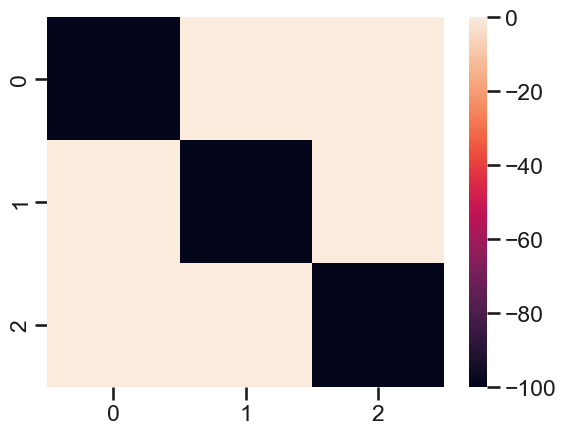

In [63]:
sns.heatmap(init_w2.T @ init_w2 - init_w1 @ init_w1.T)

In [ ]:
init_w2

In [38]:
lmda = q[0][0]

In [36]:
lmda

-0.28177224170437687

In [ ]:
w1w1

In [10]:
ws_empirical[100][0]

array([[[49.1934955,  0.       ,  0.       ],
        [ 0.       , 49.1934955,  0.       ],
        [ 0.       ,  0.       , 49.1934955]]])

In [22]:
diffs = [np.linalg.norm(emp - anal) for (emp, anal) in zip(ws_empirical[0.01], ws_analytical[0.01])]

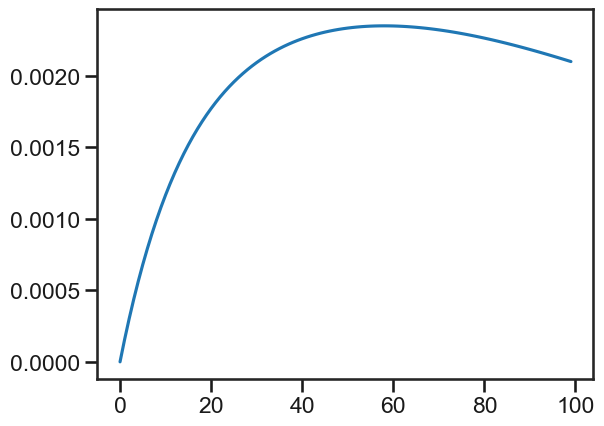

In [23]:
plt.plot(diffs)

In [14]:
ws_analytical[100][0] - ws_empirical[100][0]

array([[[ 2.84217094e-14,  2.28491476e-14, -2.08963820e-14],
        [ 2.73817693e-14,  7.10542736e-15,  7.07192674e-15],
        [-3.02242798e-14, -7.72726674e-15, -2.84217094e-14]]])

In [8]:
w2w2s_empirical[100][0]

array([[20.,  0.,  0.],
       [ 0., 20.,  0.],
       [ 0.,  0., 20.]])

In [9]:
w2w2s_analytical[100][0]

array([[1.21000000e+02, 1.85447884e-14, 3.95193305e-14],
       [2.60192161e-14, 1.21000000e+02, 4.07614668e-14],
       [3.63346148e-14, 4.99319403e-14, 1.21000000e+02]])

In [9]:
losses_list_analytical[0.01]

[3.2628125714552527,
 3.2089203218836673,
 3.157144943980675,
 3.107354410385355,
 3.0594273795061038,
 3.013252174262584,
 2.9687258751624737,
 2.9257535130747776,
 2.8842473491527314,
 2.8441262311216096,
 2.805315016636625,
 2.767744055679206,
 2.7313487250340995,
 2.6960690088057486,
 2.661849119715481,
 2.6286371565925193,
 2.596384794048838,
 2.5650470008250963,
 2.5345817837242217,
 2.50494995442095,
 2.4761149167580623,
 2.4480424724204664,
 2.4207006431225304,
 2.394059507657394,
 2.368091052343537,
 2.342769033567421,
 2.318068851264646,
 2.293967432308325,
 2.270443122884696,
 2.2474755890342575,
 2.225045724623476,
 2.203135566089043,
 2.181728213364766,
 2.16080775646169,
 2.1403592072258166,
 2.1203684358456,
 2.100822111724084,
 2.0817076483684507,
 2.063013151983762,
 2.044727373487893,
 2.0268396636917694,
 2.0093399314131966,
 1.99221860431427,
 1.9754665922716748,
 1.959075253106617,
 1.9430363605165841,
 1.9273420740651201,
 1.9119849110981844,
 1.8969577204669066,


In [19]:
np.diag([1,2] + [2,3])

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 3]])

In [47]:
losses_list_empirical[0.01]

[1.0887293427676292,
 1.0729129577832786,
 1.0576897434821708,
 1.0430273702507034,
 1.028895816909269,
 1.0152671731179341,
 1.0021154614664167,
 0.9894164770107805,
 0.9771476423039145,
 0.9652878762115715,
 0.9538174750166293,
 0.9427180044963841,
 0.9319722018154127,
 0.921563886213364,
 0.9114778775860296,
 0.901699922161719,
 0.8922166245654759,
 0.8830153856428568,
 0.8740843454843865,
 0.8654123311527349,
 0.8569888086682649,
 0.8488038388558192,
 0.8408480366972959,
 0.8331125338714221,
 0.8255889441947519,
 0.8182693317068593,
 0.8111461811683965,
 0.80421237076355,
 0.7974611468187801,
 0.7908861003679084,
 0.7844811454098237,
 0.7782404987195978,
 0.7721586610867844,
 0.7662303998663325,
 0.7604507327379924,
 0.7548149125794963,
 0.7493184133672499,
 0.7439569170258834,
 0.7387263011548829,
 0.7336226275667187,
 0.7286421315764905,
 0.7237812119881777,
 0.719036421727165,
 0.71440445907288,
 0.7098821594491389,
 0.705466487733237,
 0.7011545310479141,
 0.6969434920031723,
 

In [62]:
w = ws_empirical[lmda][0]
1/(2*batch_size) * np.linalg.norm(w @ X - Y)**2

2.721823356919073

In [61]:
np.linalg.norm((w @ X - Y))

7.378107286993153

In [58]:
w[0]

array([[0.49193496, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.49193496, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.49193496, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.49193496, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.49193496]])

In [52]:
(w@X - Y)[0]

array([[ 0.16237539,  0.16064873,  1.53878758, -1.67834349,  0.77421073,
         0.55091759,  1.54248923,  0.17009817, -0.12319777, -0.2341249 ],
       [-1.75122721,  0.55465584, -0.76200559, -0.40523803,  1.32383898,
         0.47315547, -0.8081149 , -1.43916068, -1.12969471, -1.10778487],
       [-1.60599465, -0.09133647,  0.10944904,  2.02698495,  0.46624498,
         1.30204269,  0.98213495,  0.42080348, -0.78920265, -1.20653358],
       [-1.32768272,  0.28794225,  1.12531472, -1.04409421, -1.79155259,
         1.04024191, -0.61249603, -0.73095069,  1.32060064,  0.74994659],
       [-1.21328915,  0.38625372,  0.14766807, -1.08519205, -1.48935009,
         0.70259221, -0.03219083,  1.81050777,  0.29026117, -1.43126207]])

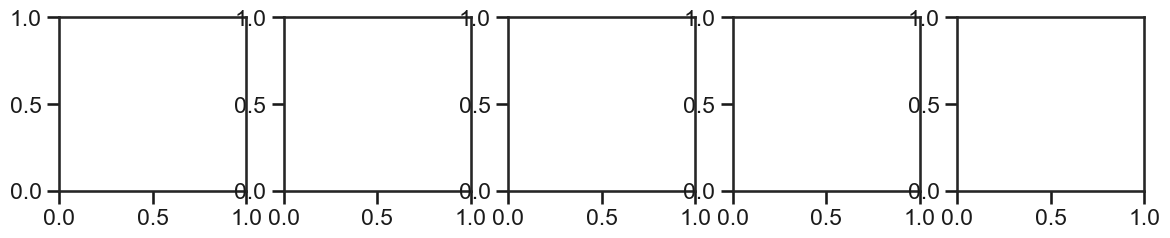

In [23]:
fig, axs_ = plt.subplots(len(lmdas), 5, figsize=(14, 4.5 * len(lmdas)/2), sharex=True)


In [27]:
axs = axs_[0]

In [29]:


for i in range(len(lmdas)):
    axs = axs_[i]
    print(f'mode: {i}, axs: {axs}')

mode: 0, axs: Axes(0.125,0.11;0.133621x0.77)
